<a href="https://colab.research.google.com/github/Sylvia53/tibame1224/blob/main/%E5%9C%98%E5%B0%88Bank_AutoGluon_2_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 資料清洗&前處理

In [238]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [239]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from xgboost import XGBClassifier
import os

import joblib

In [240]:
data = pd.read_csv("/content/drive/MyDrive/團專bank/bank-full-utf8.csv")
display(data.shape)
display(data.head(3))

(45211, 17)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no


In [241]:
df = data.copy()

# 刪除有疑慮的欄位
df = data.drop(columns=["month", "day"])

# 刪除有unknown的行
df = df[~df.isin(["unknown"]).any(axis=1)]

df.shape


(7842, 15)

In [242]:

# 將balance < 0 的刪除
# balance < 0  的刪除後， padys=-1 的就沒了，pdays的最小值變成 1
df = df[df["balance"] >= 0 ]
df.shape

(7371, 15)

In [243]:
for col in df.columns:
  unknown_col = df[col].isin(["unknown"])
  if unknown_col.any():
    print(f"含有unknown的特徵: {col}, 數量: {unknown_col.sum()}")
unknown_row = df.isin(["unknown"]).any(axis=1)
print(f"總行數: {df.shape[0]}")
print(f"含有unknown的行數: {unknown_row.sum()}")



總行數: 7371
含有unknown的行數: 0


In [244]:
column_info = []
for col in df.columns:
  info_dtype = df[col].dtype
  info_isna = df[col].isna().any()
  info_nunique = df[col].nunique()
  info_min = df[col].min()
  info_max = df[col].max()
  info_unique_20 = df[col].unique()[0: 20]

  c = [col, info_dtype, info_isna, info_nunique, info_min, info_max, info_unique_20]
  column_info.append(c)
columns = ["col_name", "dtype", "isna", "unique_num", "min", "max", "unique_20"]
column_info_df = pd.DataFrame(column_info, columns=columns)
display(column_info_df)

# column_info_df.to_csv("column_info_bank.csv")


,col_name,dtype,isna,unique_num,min,max,unique_20
0,age,int64,False,70,18,89,"[33, 36, 44, 26, 51, 30, 34, 49, 47, 40, 38, 54, 52, 48, 45, 39, 37, 43, 35, 50]"
1,job,object,False,11,admin.,unemployed,"[admin., services, management, blue-collar, technician, unemployed, entrepreneur, housemaid, retired, self-employed, student]"
2,marital,object,False,3,divorced,single,"[married, single, divorced]"
3,education,object,False,3,primary,tertiary,"[tertiary, secondary, primary]"
4,default,object,False,2,no,yes,"[no, yes]"
5,balance,int64,False,2764,0,81204,"[882, 3444, 2415, 0, 1324, 172, 3132, 1005, 873, 1243, 1631, 119, 58, 6203, 105, 1533, 228, 1623, 1484, 494]"
6,housing,object,False,2,no,yes,"[no, yes]"
7,loan,object,False,2,no,yes,"[no, yes]"
8,contact,object,False,2,cellular,telephone,"[telephone, cellular]"
9,duration,int64,False,957,5,2219,"[39, 144, 73, 140, 119, 21, 449, 175, 86, 81, 200, 79, 58, 303, 324, 80, 161, 297, 146, 120]"


In [245]:
# 目標變數編碼

df[col] = df[col].map({"yes": 1, "no": 0})
# display(df["y"].value_counts())


In [246]:

# 二元特徵及目標變數編碼
ordinal_features = ["default", "housing", "loan"]

for col in ordinal_features:
  df[col] = df[col].map({"yes": 1, "no": 0})


In [247]:

# 提取特徵變數及目標變數

X = df.drop(columns=["y"])
y = df["y"]
print(X.shape, y.shape)



(7371, 14) (7371,)


In [248]:
# 切分訓練組、驗證組、測試組

# 切出測試集(保留最後評估用)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

# 剩下的資料切成訓練、驗證集
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, shuffle=True, stratify=y_temp)

display(X_temp.shape, y_temp.shape)
display(X_test.shape, y_test.shape)
display(X_train.shape, y_train.shape)
display(X_val.shape, y_val.shape)
print(X_train.index.equals(y_train.index))
print(X_test.index.equals(y_test.index))
print(X_val.index.equals(y_val.index))


(5896, 14)

(5896,)

(1475, 14)

(1475,)

(4422, 14)

(4422,)

(1474, 14)

(1474,)

True
True
True


In [249]:

display(X_train.dtypes.value_counts())

,count
int64,9
object,5


In [250]:
# 欄位分類

int_columns = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous'] # 數值型欄位，做標準化縮放
ordinal_columns = ["education", "contact"] # 類別型欄位，做標籤編碼
binary_columns = ["default", "housing", "loan"] # 二元欄位，前面已轉換，預處理不再做
ohe_columns = ['job', 'marital', 'poutcome'] # 類別型欄位，做ohe


all_columns = int_columns +  ordinal_columns + binary_columns + ohe_columns
print(len(all_columns))
# all_columns



14


In [251]:
# 設置前處理器

categories_order = [
    ["primary", "secondary", "tertiary"],
    ['cellular', 'telephone']
]

preprocessor = ColumnTransformer(transformers=[
    ("int", StandardScaler(), int_columns),
    ("ordinal", OrdinalEncoder(categories=categories_order), ordinal_columns),
    ("passthrough", "passthrough", binary_columns),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ohe_columns)
])



In [252]:
# 執行預處理

X_train_preproceed = preprocessor.fit_transform(X_train) # 訓練組預處理
X_val_preproceed = preprocessor.transform(X_val) # 測試組預處




In [253]:

# 整理欄位

ohe_columns = list(preprocessor.named_transformers_["ohe"].get_feature_names_out()) # 取得預處理器中的ohe欄位名稱
all_preprocessed_columns = int_columns +  ordinal_columns + binary_columns + ohe_columns # 整合所有欄位名稱
len(all_preprocessed_columns)

X_train_preproceed = pd.DataFrame(X_train_preproceed, columns=all_preprocessed_columns, index=X_train.index) # 訓練組重新生成dataframe
X_val_preproceed = pd.DataFrame(X_val_preproceed, columns=all_preprocessed_columns, index=X_val.index) # 測試組重新生成dataframe

display(X_train_preproceed.shape, y_train.shape)
display(X_val_preproceed.shape, y_val.shape)

display(X_train_preproceed.head(3))
display(X_val_preproceed.head(3))



(4422, 28)

(4422,)

(1474, 28)

(1474,)

,age,balance,duration,campaign,pdays,previous,education,contact,default,housing,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success
35777,-0.245234,-0.435792,-0.737583,-0.678116,1.319633,-0.223202,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
40885,0.541785,0.210741,-0.102427,-0.678116,-1.024494,-0.409674,2.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
37975,-1.207146,-0.441751,5.088918,-0.042948,1.194375,-0.409674,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


,age,balance,duration,campaign,pdays,previous,education,contact,default,housing,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success
41264,-0.332680,-0.468864,-0.288739,-0.678116,-0.228206,-0.409674,2.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
43930,0.891571,-0.506702,-0.352255,1.227388,-1.069229,-0.223202,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
34928,-0.595020,-0.260305,-0.026208,-0.678116,0.433875,0.149743,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [254]:
# 檢查 index 是否對齊
print(X_train.index.equals(y_train.index))  # 這應該要是 True
print(X_test.index.equals(y_test.index))    # 這應該要是 True
print(X_val.index.equals(y_val.index))      # 這應該要是 True

# 合併 X 和 y 形成完整的 DataFrame
bank_train_df = pd.concat([X_train_preproceed, y_train], axis=1)
bank_val_df = pd.concat([X_val_preproceed, y_val], axis=1)
bank_test_df = pd.concat([X_test, y_test], axis=1)

# 存成 CSV
save_path = "/content/drive/MyDrive/團專bank/"  # 確保這個路徑存在
bank_train_df.to_csv(save_path + "bank_train0324.csv", index=False)
bank_val_df.to_csv(save_path + "bank_val0324.csv", index=False)
bank_test_df.to_csv(save_path + "bank_test0324.csv", index=False)

print("CSV 檔案已成功儲存！")

True
True
True
CSV 檔案已成功儲存！


# 其他三個模型

In [ ]:

# 定義模型

model_def = {
    "random_forest": {
        "model": RandomForestClassifier(n_estimators=120, max_depth=15, min_samples_leaf=3, class_weight="balanced", random_state=42),
        "cache_path": "/content/rf_model.pkl"
    },
    "xgb": {
        "model": XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42, n_estimators=100,
                    max_depth=3, learning_rate=0.2, colsample_bytree=0.8, gamma=0.1, min_child_weight=1, scale_pos_weight=2.5,
                    subsample=1, reg_alpha=0.1, reg_lambda=100),
        "cache_path": "/content/xgb_model.pkl"
    },
    "logical_reg": {
        "model": LogisticRegression(penalty='l2', C=0.1, class_weight='balanced', solver='liblinear', max_iter=1000, random_state=42),
        "cache_path": "/content/lg_model.pkl"
    },
    "autogluon": {
        "model": autogluonClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42, n_estimators=100,
                    max_depth=3, learning_rate=0.2, colsample_bytree=0.8, gamma=0.1, min_child_weight=1, scale_pos_weight=2.5,
                    subsample=1, reg_alpha=0.1, reg_lambda=100),
        "cache_path": "/content/xgb_model.pkl"
    },
}



In [256]:
# 訓練模型

for name, data in model_def.items():
  path = data["cache_path"]
  if os.path.exists(path):
    print(f"model {name} 已存在")
  else:
    model = data["model"].fit(X_train_preproceed, y_train)
    joblib.dump(model, path)
    print(f"mode {name} trained and saved")




model random_forest 已存在
model xgb 已存在
model logical_reg 已存在


In [257]:
# 對驗證組進行預測，並取得 y_score

train_model_result = {}
val_model_result = {}

for name, data in model_def.items():
  path = data["cache_path"]
  model = joblib.load(path)
  train_score = model.predict_proba(X_train_preproceed)[:, 1]
  train_pred = (train_score >= 0.5).astype(float)

  val_score = model.predict_proba(X_val_preproceed)[:, 1]
  val_pred = (val_score >= 0.5).astype(float)

  train_accuracy = accuracy_score(y_train, train_pred)
  val_accuracy = accuracy_score(y_val, val_pred)

  train_model_result[f"train_{name}"] = {"accuracy": f"{train_accuracy:.3f}", "score": train_score}
  val_model_result[f"val_{name}"] = {"accuracy": f"{train_accuracy:.3f}", "score": val_score}



train_model_result
val_model_result


{'val_random_forest': {'accuracy': '0.925',
  'score': array([0.61923193, 0.68704864, 0.13897333, ..., 0.15270747, 0.17204917,
         0.05983841])},
 'val_xgb': {'accuracy': '0.843',
  'score': array([0.551936  , 0.599698  , 0.13687988, ..., 0.12290528, 0.15912612,
         0.06075998], dtype=float32)},
 'val_logical_reg': {'accuracy': '0.816',
  'score': array([0.67192873, 0.518312  , 0.24267159, ..., 0.23495996, 0.20073938,
         0.15098404])}}

# 參數設定

In [258]:
#載入測試用資料
import pandas as pd
import numpy as np
data = pd.read_csv('/content/drive/MyDrive/團專bank/bank_train0324.csv')
data.head()

,age,balance,duration,campaign,pdays,previous,education,contact,default,housing,...,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,y
0,-0.245234,-0.435792,-0.737583,-0.678116,1.319633,-0.223202,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
1,0.541785,0.210741,-0.102427,-0.678116,-1.024494,-0.409674,2.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
2,-1.207146,-0.441751,5.088918,-0.042948,1.194375,-0.409674,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
3,-1.032253,1.190968,0.748683,-0.678116,0.407034,-0.409674,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
4,1.328804,-0.464693,-0.834974,-0.042948,1.355421,-0.223202,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0


設定檔案來源

In [259]:
# eval_metric 評估指標
# options for classification:
#  ['accuracy', 'balanced_accuracy', 'f1', 'f1_macro', 'f1_micro', 'f1_weighted',
#  'roc_auc', 'roc_auc_ovo_macro', 'average_precision', 'precision', 'precision_macro',
#  'precision_micro', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro',
# 'recall_weighted', 'log_loss', 'pac_score']
#
# Options for regression:
#  ['root_mean_squared_error', 'mean_squared_error', 'mean_absolute_error',
#  'median_absolute_error', 'mean_absolute_percentage_error','r2']
eval_metric = 'roc_auc'

# data_filename 訓練用資料的檔名
data_filename = '/團專bank/bank_train0324.csv'

# prediction_filename 模型預測結果的檔名
prediction_filename = '/output/bank/bank0324_train_prediction.csv'

# model_path 模型儲存資料夾
model_path = '/output/bank'

# leaderboard_filename 模型評比結果檔名
leaderboard_filename = '/output/bank/leaderboard_bank0324_train.csv'

In [260]:
print(data.columns)  # 列出所有欄位名稱
print(data.columns.duplicated())  # 顯示哪些欄位是重複的


Index(['age', 'balance', 'duration', 'campaign', 'pdays', 'previous',
       'education', 'contact', 'default', 'housing', 'loan', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'y'],
      dtype='object')
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False]


In [261]:
# input_field 模型輸入的欄位名稱
input_field = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous',
       'education', 'contact', 'default', 'housing', 'loan', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'poutcome_failure',
       'poutcome_other', 'poutcome_success']

# target_field 模型預測欄位名稱
target_field = "y"


### 環境設定

In [262]:
#檢查執行環境是不是Colab
environment_type = 1
environment_base_folder = ''
if environment_type == 1:
    from google.colab import drive
    drive.mount('/content/drive') # 此處需要登入google帳號
    environment_base_folder = '/content/drive/MyDrive'
    ! pip install autogluon
    ! sudo apt-get install python3-dev graphviz libgraphviz-dev pkg-config
    ! pip install pygraphviz

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pkg-config is already the newest version (0.29.2-1ubuntu3).
python3-dev is already the newest version (3.10.6-1~22.04.1).
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'sudo apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


載入資料

In [263]:
data = pd.read_csv(environment_base_folder+data_filename)
data


,age,balance,duration,campaign,pdays,previous,education,contact,default,housing,...,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,y
0,-0.245234,-0.435792,-0.737583,-0.678116,1.319633,-0.223202,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
1,0.541785,0.210741,-0.102427,-0.678116,-1.024494,-0.409674,2.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
2,-1.207146,-0.441751,5.088918,-0.042948,1.194375,-0.409674,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
3,-1.032253,1.190968,0.748683,-0.678116,0.407034,-0.409674,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
4,1.328804,-0.464693,-0.834974,-0.042948,1.355421,-0.223202,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4417,1.678590,0.995221,-1.067864,3.132892,-0.335571,-0.409674,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
4418,2.465609,-0.506702,1.718355,-0.678116,-1.149753,0.149743,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
4419,1.591143,0.049256,0.117761,-0.042948,-0.031371,-0.409674,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0
4420,-1.119699,3.353427,2.878574,-0.678116,1.614886,-0.036729,2.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1


# 訓練模型

In [213]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [ ]:
#這個調參以後不能印

# working_field = input_field.copy()
# working_field.append(target_field)


# model = TabularPredictor(label=target_field, eval_metric= "f1" ).fit(
#     train_data=data[working_field],
#     excluded_model_types=['KNN', 'EXTRA', 'LogisticRegression'],
#     presets="best_quality",  # 可選 "best_quality", "high_quality", "good_quality", "medium_quality"
#     time_limit=3600  # 設定訓練時間限制 (秒)
# )

In [266]:
working_field = input_field.copy()
working_field.append(target_field)

model = TabularPredictor(label=target_field, eval_metric= eval_metric , path=environment_base_folder+model_path).fit(train_data=data[working_field],num_bag_folds=5)

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       8.69 GB / 12.67 GB (68.6%)
Disk Space Avail:   57.54 GB / 100.00 GB (57.5%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high'         : Strong accuracy with fast inference spee

### <font color='blue'>最佳模型名稱</font>

### <font color='blue'>預測問題種類</font>

In [267]:
model.problem_type

'binary'

### <font color='blue'>評估指標</font>

In [268]:
model.eval_metric

roc_auc

### <font color='blue'>leaderboard</font>

In [269]:
leaderboard = model.leaderboard(extra_info=True, silent=True)
leaderboard.to_csv(environment_base_folder+leaderboard_filename)
model.leaderboard(silent=True)

/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")
/usr/local/lib/python3.11/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you t

,model,score_val,eval_metric,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.893223,roc_auc,0.960999,158.632668,0.001240,0.297469,2,True,14
1,CatBoost_BAG_L1,0.891830,roc_auc,0.059167,23.031130,0.059167,23.031130,1,True,7
2,XGBoost_BAG_L1,0.887411,roc_auc,0.073784,14.956571,0.073784,14.956571,1,True,11
3,LightGBMXT_BAG_L1,0.885235,roc_auc,0.454939,47.298998,0.454939,47.298998,1,True,3
4,LightGBM_BAG_L1,0.885170,roc_auc,0.048499,23.301574,0.048499,23.301574,1,True,4
5,RandomForestEntr_BAG_L1,0.879845,roc_auc,0.281232,2.202662,0.281232,2.202662,1,True,6
6,RandomForestGini_BAG_L1,0.878252,roc_auc,0.289349,2.508254,0.289349,2.508254,1,True,5
7,NeuralNetTorch_BAG_L1,0.877081,roc_auc,0.152678,73.034815,0.152678,73.034815,1,True,12
8,LightGBMLarge_BAG_L1,0.874913,roc_auc,0.067092,27.296220,0.067092,27.296220,1,True,13
9,NeuralNetFastAI_BAG_L1,0.863821,roc_auc,0.197398,56.108591,0.197398,56.108591,1,True,10


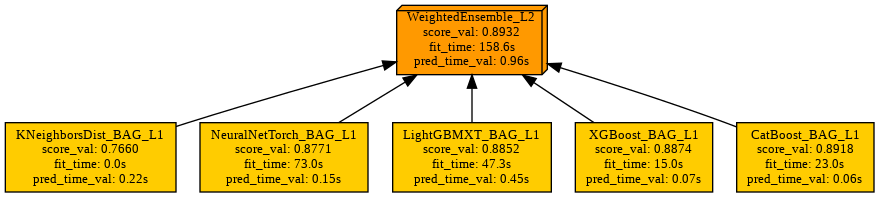

In [270]:
if environment_type == 1:
  path_to_png = model.plot_ensemble_model()
  from IPython.display import Image, display
  display(Image(filename=path_to_png))

# 輸出預測結果

In [271]:
if (model.problem_type != 'regression'):
  prediction_p = model.predict_proba(data)
prediction = model.predict(data)

In [272]:
pred_data = data.copy()
pred_data['/output/bank'] = prediction
pred_data = pd.concat([pred_data,prediction_p], axis=1, join='inner')
pred_data.to_csv(environment_base_folder+prediction_filename)

In [273]:
model.evaluate(data)

{'roc_auc': 0.9579498722118138,
 'accuracy': 0.898236092265943,
 'balanced_accuracy': 0.8311587815199319,
 'mcc': 0.7065684966080809,
 'f1': 0.7663551401869159,
 'precision': 0.8415051311288484,
 'recall': 0.7035271687321258}

In [274]:
y_pred = model.predict(data[input_field])


In [275]:
from sklearn.metrics import classification_report

prediction = model.predict(data)
# y_true 是真實標籤，y_pred 是模型的預測標籤
print(classification_report(data[target_field], prediction, digits=4))


              precision    recall  f1-score   support

           0     0.9123    0.9588    0.9350      3373
           1     0.8415    0.7035    0.7664      1049

    accuracy                         0.8982      4422
   macro avg     0.8769    0.8312    0.8507      4422
weighted avg     0.8955    0.8982    0.8950      4422



# 儲存模型

In [276]:
import pickle

result = {}
result['input_field'] = input_field
result['target_field'] = target_field

with open(environment_base_folder+model_path+'/Bank_AutoML_train0325.bin', 'wb') as handle:
    pickle.dump(result, handle)


In [277]:
model.save()

TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/content/drive/MyDrive/output/bank")


# 欄位重要性

In [278]:
model.feature_importance(data)

Computing feature importance via permutation shuffling for 28 features using 4422 rows with 5 shuffle sets...
	132.07s	= Expected runtime (26.41s per shuffle set)
	102.28s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
duration,0.177343,0.008833,7.361304e-07,5,0.195531,0.159155
pdays,0.056209,0.002181,2.715861e-07,5,0.060701,0.051718
poutcome_success,0.050136,0.003027,1.586798e-06,5,0.056368,0.043903
balance,0.022920,0.000742,1.313649e-07,5,0.024447,0.021393
age,0.020757,0.000265,3.174257e-09,5,0.021302,0.020212
previous,0.014777,0.000348,3.693465e-08,5,0.015494,0.014060
education,0.014260,0.000761,9.689690e-07,5,0.015827,0.012693
campaign,0.013332,0.000728,1.063414e-06,5,0.014831,0.011833
housing,0.011625,0.001828,7.098085e-05,5,0.015389,0.007862
job_blue-collar,0.002611,0.000304,2.169864e-05,5,0.003237,0.001985


In [279]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba[1])

# 計算 F1-score
f1_scores = (2 * precision * recall) / (precision + recall)

# 找到 F1-score 最大的閾值
best_threshold = thresholds[f1_scores.argmax()]
print(f"最佳閾值: {best_threshold}")


NameError: name 'y_pred_proba' is not defined

# 驗證組

評估指標

In [227]:
eval_metric = 'roc_auc'
# eval_metric = 'r2'

# data_filename 預測資料來源的檔名
data_filename = '/output/bank/bank0324_val_prediction.csv'

# prediction_filename 模型預測結果的檔名
prediction_filename = '/output/bank/bank0324_val_prediction.csv'

# model_path 模型儲存資料夾
model_path = '/output/bank/'

載入資料

In [150]:
data = pd.read_csv(environment_base_folder+data_filename)
data

,Unnamed: 0,age,balance,duration,campaign,pdays,previous,education,contact,default,...,job_unemployed,marital_divorced,marital_married,marital_single,poutcome_failure,poutcome_other,poutcome_success,預測結果,0,1
0,41264,-0.332680,-0.468864,-0.288739,-0.678116,-0.228206,-0.409674,2.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0.526357,0.473643
1,43930,0.891571,-0.506702,-0.352255,1.227388,-1.069229,-0.223202,2.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,0.437643,0.562357
2,34928,-0.595020,-0.260305,-0.026208,-0.678116,0.433875,0.149743,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0.910379,0.089621
3,33153,-0.595020,1.888151,-0.978942,0.592220,-0.595035,-0.409674,2.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,0.988300,0.011700
4,42520,-1.032253,-0.387824,0.820667,2.497724,-0.174524,-0.409674,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0.704965,0.295035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1469,41130,0.979018,-0.333003,-0.843442,-0.678116,-1.203435,-0.409674,2.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0.962774,0.037226
1470,32405,-0.245234,-0.452179,-0.017739,0.592220,1.078063,-0.223202,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0.954490,0.045510
1471,30038,-0.420127,-0.319893,-0.483520,0.592220,0.228093,-0.409674,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,0.924644,0.075356
1472,33567,0.629231,0.472631,-0.077020,-0.042948,0.791757,-0.409674,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0.925307,0.074693


載入模型

In [228]:
from autogluon.tabular import TabularDataset, TabularPredictor

In [229]:
import pickle
with open(environment_base_folder+model_path+'/used_field.bin', 'rb') as handle:
  used_field = pickle.load(handle)

input_field = used_field['input_field']
target_field = used_field['target_field']
working_field = input_field.copy()
working_field.append(target_field)

model = TabularPredictor.load(environment_base_folder+model_path)

輸出預測結果

In [280]:
prediction_p = None
if (model.problem_type != 'regression'):
  prediction_p = model.predict_proba(data)
prediction = model.predict(data)

In [231]:
from sklearn.linear_model import LogisticRegression

# 假設 model 是 LogisticRegression 模型
if hasattr(model, 'coef_'):  # LogisticRegression 有 coef_ 屬性
    # 判斷是分類問題
    prediction_p = model.predict_proba(data)  # 預測機率
    prediction = model.predict(data)  # 預測類別


In [232]:
pred_data = data.copy()
pred_data['預測結果'] = prediction
pred_data = pd.concat([pred_data,prediction_p], axis=1, join='inner')
pred_data.to_csv(environment_base_folder+prediction_filename)

評估分數

In [281]:
model.evaluate(data)

{'roc_auc': 0.9579498722118138,
 'accuracy': 0.898236092265943,
 'balanced_accuracy': 0.8311587815199319,
 'mcc': 0.7065684966080809,
 'f1': 0.7663551401869159,
 'precision': 0.8415051311288484,
 'recall': 0.7035271687321258}

In [282]:
from sklearn.metrics import classification_report

prediction = model.predict(data)
# y_true 是真實標籤，y_pred 是模型的預測標籤
print(classification_report(data[target_field], prediction, digits=4))


              precision    recall  f1-score   support

           0     0.9123    0.9588    0.9350      3373
           1     0.8415    0.7035    0.7664      1049

    accuracy                         0.8982      4422
   macro avg     0.8769    0.8312    0.8507      4422
weighted avg     0.8955    0.8982    0.8950      4422



欄位重要性

In [283]:
output = ''
if target_field in data:
    output = model.feature_importance(data)
output

Computing feature importance via permutation shuffling for 28 features using 4422 rows with 5 shuffle sets...
	133.33s	= Expected runtime (26.67s per shuffle set)
	93.95s	= Actual runtime (Completed 5 of 5 shuffle sets)


,importance,stddev,p_value,n,p99_high,p99_low
duration,0.177343,0.008833,7.361304e-07,5,0.195531,0.159155
pdays,0.056209,0.002181,2.715861e-07,5,0.060701,0.051718
poutcome_success,0.050136,0.003027,1.586798e-06,5,0.056368,0.043903
balance,0.022920,0.000742,1.313649e-07,5,0.024447,0.021393
age,0.020757,0.000265,3.174257e-09,5,0.021302,0.020212
previous,0.014777,0.000348,3.693465e-08,5,0.015494,0.014060
education,0.014260,0.000761,9.689690e-07,5,0.015827,0.012693
campaign,0.013332,0.000728,1.063414e-06,5,0.014831,0.011833
housing,0.011625,0.001828,7.098085e-05,5,0.015389,0.007862
job_blue-collar,0.002611,0.000304,2.169864e-05,5,0.003237,0.001985


圖表

ROC curve

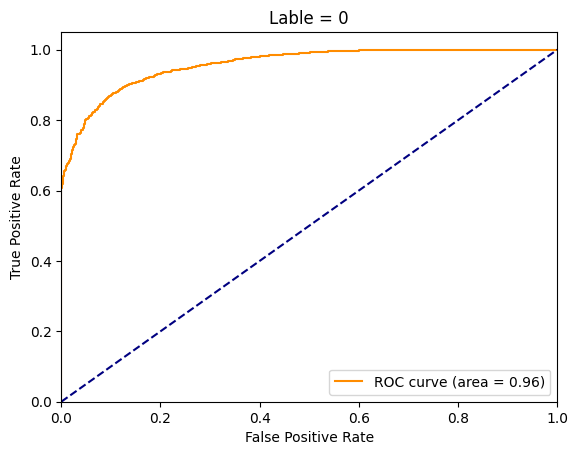

In [284]:
from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt

class_labels = model.class_labels

if target_field in data:
    if (model.problem_type != 'regression'):
        if (model.problem_type == 'binary'):
            class_labels = [class_labels[0]]

        for n,label in enumerate(class_labels):
            roc_score = roc_auc_score(np.array(data[target_field] == label,dtype='int'), prediction_p[label])

            fpr, tpr, thresholds = metrics.roc_curve(np.array(data[target_field] == label,dtype='int'), prediction_p[label])

            plt.figure()
            plt.plot(fpr,tpr,color="darkorange",label="ROC curve (area = %0.2f)" % roc_score)
            plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title("Lable = "+str(label))
            plt.legend(loc="lower right")
            plt.show()

Confusion Matrix

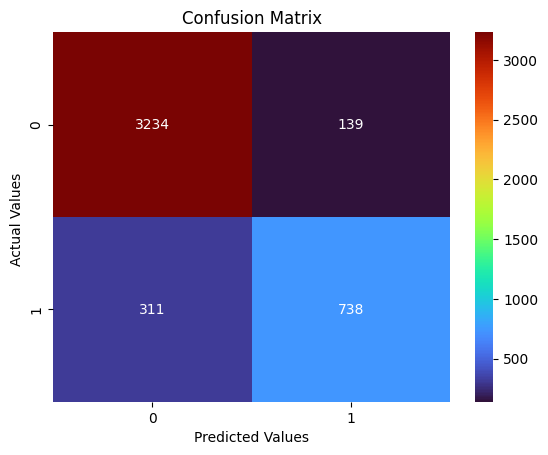

In [285]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

if target_field in data:
    if (model.problem_type != 'regression'):
        conf_matrix = (confusion_matrix(data[target_field], prediction))
        conf_matrix_df = pd.DataFrame(conf_matrix, model.class_labels, model.class_labels)
        conf_matrix_df

        fx = sns.heatmap(conf_matrix_df, annot=True, cmap='turbo', fmt='d')

        fx.set_title('Confusion Matrix')
        fx.set_xlabel('Predicted Values')
        fx.set_ylabel('Actual Values ')